<a href="https://colab.research.google.com/github/nataliasiennicka/cena_ubezpieczenia/blob/main/cena_ubezpieczenia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importy

In [8]:
import numpy as np  #do obliczeń matematycznych i macierzowych
import pandas as pd  #do pracy na DataFrame
import seaborn as sns #do stworzenia wykresów
import matplotlib.pyplot as plt #do stworzenia wykresów
import plotly.graph_objs as go #konwecja graph objects -> go  - moduł 
from plotly.offline import iplot # do wykresów interaktywnych

#Ocena modeli:
from sklearn.dummy import DummyRegressor #do porównania modeli

## Wczytanie danych

In [3]:
insurance = pd.read_csv('insurance.csv')
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# Problem do rozwiązania: jaki będzie koszt ubezpieczenia w zależności od określonych cech danej osoby? 

####Kategorie w posiadanej tabeli danych:
####**age** - wiek badanych osób
####**sex** - płeć (famale lub male)
####**bmi** - wskaźnik BMI inaczej wskaźnika masy ciała, obliczamy dzieląc masę ciała (w kilogramach) przez wzrost do kwadratu (w metrach). Wskaźnik ten wykorzystywany jest przede wszystkim do oceny ryzyka ryzyka pojawienia się groźnych chorób
####**children** - liczba dzieci, które posiada dana osoba
####**smoker**	 - czy osoba jest paląca czy nie (yes/no)
####**region** - region w którym mieszka osoba badna 
#### **charges** - kwota ubezpieczenia


## Wstępne rozpoznanie danych za pmocą PANDAS - PROFILING

In [ ]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
profile =ProfileReport(insurance, title="Koszt ubezpieczenia")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

W danych nie odnaleziono wartości brakujących.
Istnieją dwie wartości zduplikowane, jednak założono, że istnieje taka możliwość, że w przypadku obu obserwacji zanotowano te same cechy.

Na podstawie wstępnego przeglądania danych, można zaobserwować dużą zależność w wysokości ubezpieczenia od wieku oraz tego czy dana osoba jest paląca, bądź też nie.

Warto jednak przyjrzeć się danym dokładniej:

# Korelacja pomiędzy ziennymi numerycznymi

In [4]:
#Obliczenie koralacji dla cech, które posiadają wartości numeryczne
corr = insurance.corr()
corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


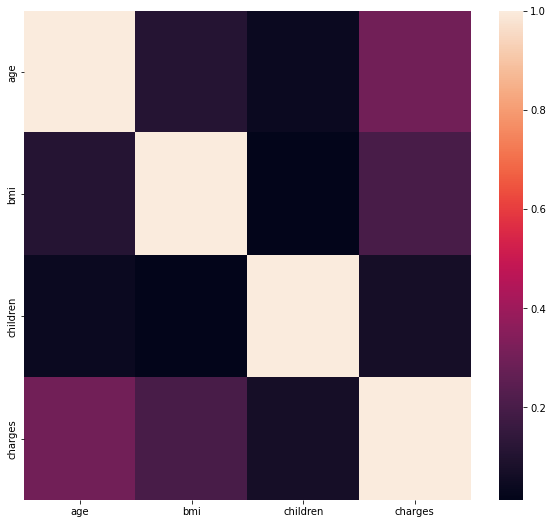

In [7]:
plt.figure(figsize=(10,9))
sns.heatmap(corr)
display()

Na podstawie Heat Map, można dostrzec, że analizując zmienne numeryczne, największy wpływ na koszt ubezpieczenia ma wiek, następnie wskaźnik BMI natomiast najmniejszy wpływ ma liczba posiadanych dzieci.

#Badznie kolejnych cech

## Age

In [27]:
# określenie przedziału wieku badanych
print(f'Wiek badanych jest w przedziale:')
print(insurance['age'].min())
print (insurance['age'].max())

Wiek badanych jest w przedziale:
18
64


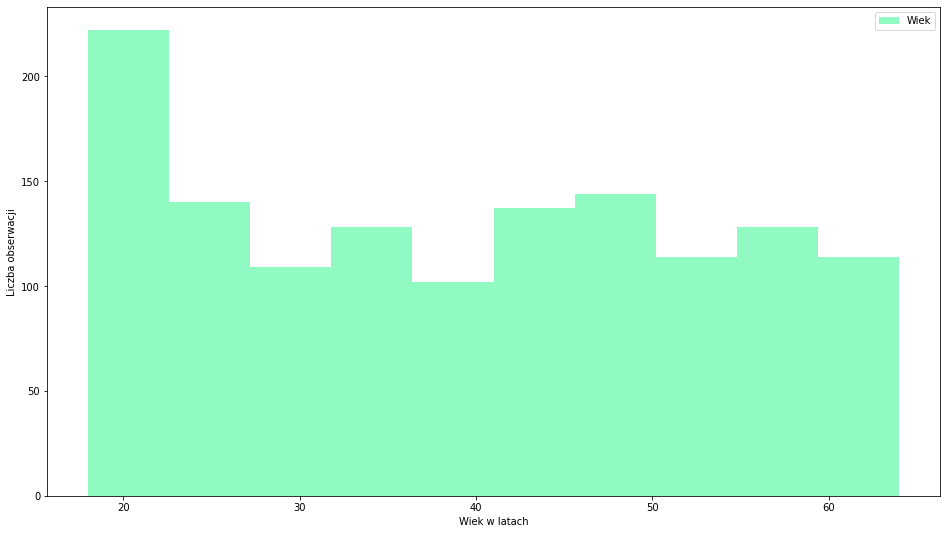

In [50]:
#Histogram przedstawiający rozkłąd wieku wśród obserwowanych osób
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(insurance['age'], 
        label="Wiek", 
        bins=10,
        color='#90FAC2')  

ax.legend()
ax.set_xlabel('Wiek w latach')
ax.set_ylabel('Liczba obserwacji')
plt.show()

Można dostrzec, że dużą grupę w osobach badanych stanowi grupa ludzi powiędzy 18, a 25 rokiem, żecia, jednak ilość osób w pozostałm wieku rozkłada się rónowiernie, więc stwierdzono, że dane w tej kategorii są reprezentatywne

In [48]:


trace1 = go.Scatter(
    x = insurance.age,
    y = insurance.charges,
    mode = 'markers',
    name = 'Kwota ubezpieczenia',
    marker = dict(color='rgba(0,255,200, 0.8)'),
    text = "wiek, kwota ubezpieczenia"
)



data = [trace1]
layout = dict(title = 'Zależność kwoty ubezpieczenia od wieku danej osoby',
xaxis = dict(title= 'Wiek w latach')
)
fig = dict(data = data, layout = layout)
iplot(fig)

Na podstawie powyższego wykresu można zaobserwować zależność wzrostu kwoty ubezpieczenia od wieku. Widać także, że kwoty te układają się w trzech oddzielnych pasach. Sugeruje to, że kwota ta, zależy od jeszcze conajmniej innego czynnika, dzięki któremu powsają obserwowane zależności.

## BMI:

Licznik BMI według podstawowej klasyfikacji wygląda następująco:

- niedowaga < 18,5

- wartość prawidłowa: (18,5-24,9)

- nadwaga: (25-29,9),

- otyłość ≥30 

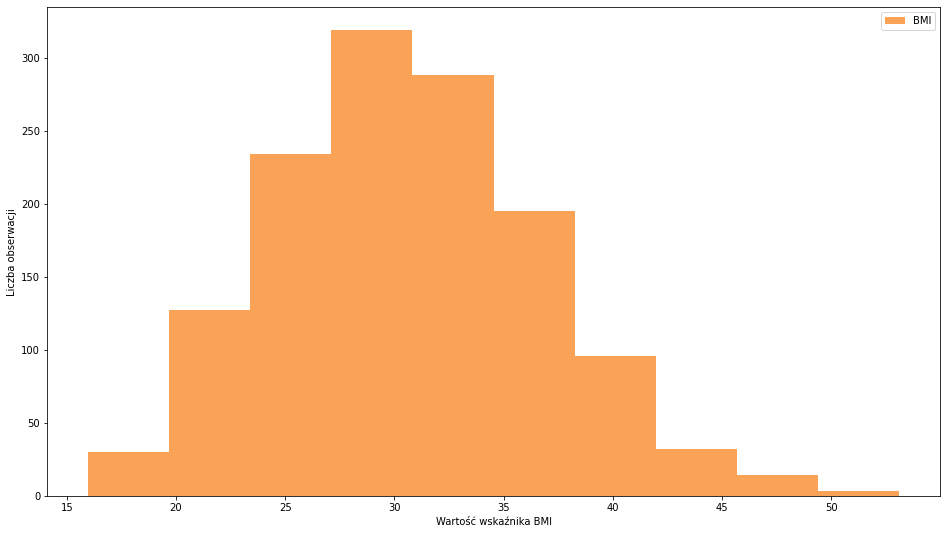

In [51]:
#Histogram przedstawiający rozkład wskażnika BMI wśród obserwowanych osób
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(insurance['bmi'], 
        label="BMI", 
        bins=10,
        color='#FAA255')  

ax.legend()
ax.set_xlabel('Wartość wskaźnika BMI')
ax.set_ylabel('Liczba obserwacji')
plt.show()

Można tu zaobserwować, że znaczna część osób odznacza się wskaźnikiem BMI, który sugeruje nadwagę, wśród badanej grupy

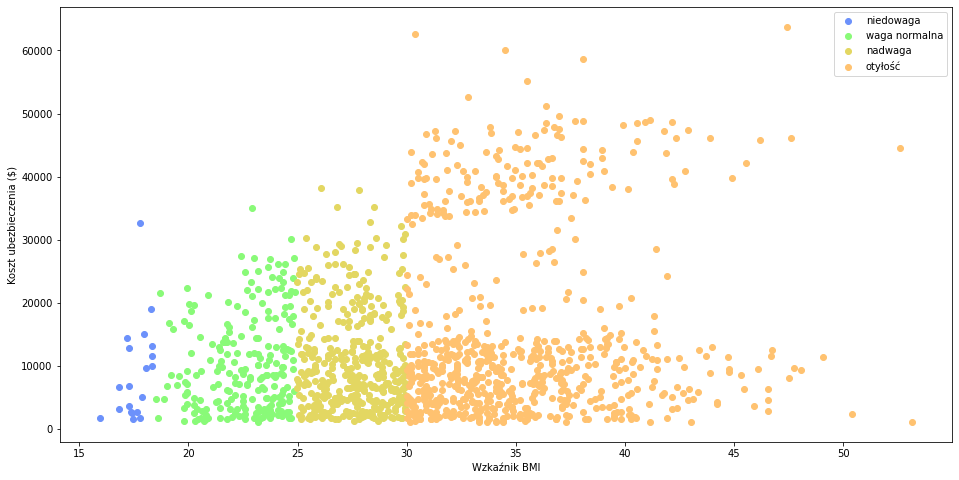

In [74]:
#Zdefiniowanie kategorii wagi, według wskaźnika BMI:
under_weight = insurance.loc[insurance['bmi']<18.5]
normal_weight = insurance.loc[(insurance['bmi']>=18.5)&(insurance['bmi']<24.9),:]
overweight = insurance.loc[(insurance['bmi']>=24.9)&(insurance['bmi']<30),:]
obesity= insurance.loc[insurance['bmi']>=30]

#Stworzenie wykresu zależności wagi od kosztu ubezpieczenia z oznaczeniem kolorem każdej z kategorii wynikającej z BMI
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(under_weight['bmi'], under_weight['charges'], color='#6C91FB', label='niedowaga')
ax.scatter(normal_weight['bmi'], normal_weight['charges'], color='#89FA78', label='waga normalna')
ax.scatter(overweight['bmi'], overweight['charges'], color='#E3D762', label='nadwaga')
ax.scatter(obesity['bmi'], obesity['charges'], color='#FFC270', label='otyłość')


ax.set_xlabel('Wzkaźnik BMI')
ax.set_ylabel('Koszt ubezbieczenia ($)')

ax.legend()
plt.show()

Dzięki prezentowanemu powyżej wykresowi, można zauważyć, że koszty ubezpieczenia rosną wzrast ze wzrostem wskaźnika BMI. Tak na przykład koszty ubezpieczenia dla ludzi znajdującej się w grupie osób otyłych, w skrajnych przypadkach są prawie dwa razy większe niż najbardziej kosztowne ubezpieczenie wśród osób o wadze normalnej.

## Sex

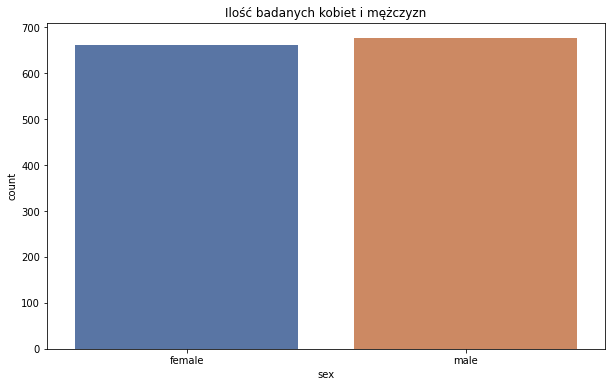

In [87]:
#Stworzenie wykresów słupkowych prezentujących liczbę przebadanych kobiet i mężczyzn
plt.figure(figsize=(10,6))
sns.countplot(data=insurance, 
              x='sex',
              palette = "deep")
plt.title('Ilość badanych kobiet i mężczyzn')
plt.show()

Możemy zaobserwować, że ilość badanych kobiet oraz mężczyzn jest bardzo zbliżona, dzięki temu możemy usnać, że dane są reprezentatywne, ponieważ obserwacje po równo rozkładają się dla każdej z płci.

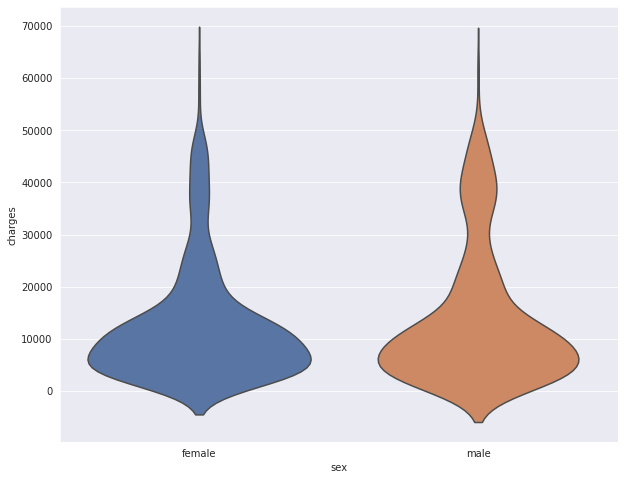

In [93]:
#Stworzenie wykresu skrzypcowego dla kategorii 'sex'
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
sns.violinplot(data=insurance, x='sex', y='charges',
               inner=None,
               palette = "deep")

Na powyższym wykresie widać także, że koszt upezbieczenia rozkłada się bardzo podobnie dla obu płci. 

Zdecydowano się nie używać tej kategorii w tworzeniu modeli, ponieważ jej wpływ na koszt jest znikomy oraz płeć nie powinna mieć wpływu na koszty związane z leczeniem. Gdyby w tym problemi wzięto ją pod uwagę wystąpiłby problem z uprzedzeniami, którego należy unikać podczas opracowania modelu.

## Children

In [99]:
print(f'Największa liczba dzieci jaką posiada badana osoba to: {insurance["children"].max()}')

Największa liczba dzieci jaką posiada badana osoba to: 5


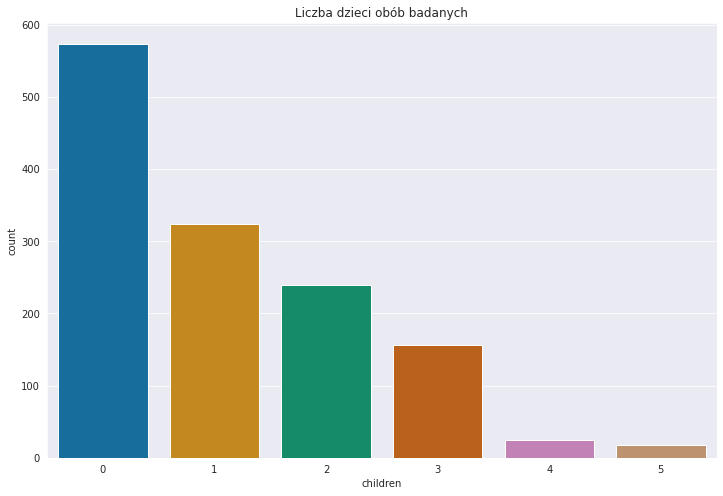

In [129]:
# Wykres obrazujący posiadną liczbę dzieci przez osoby badane
plt.figure(figsize=(12,8))
sns.countplot(data=insurance, 
              x='children',
              palette = "colorblind")
plt.title('Liczba dzieci obób badanych')
plt.show()

W przebadanej grupie najwięcej osób było bezdzietnych. Niewielką grupę stanowią także osoby, które mają 4 lub 5 dzieci.

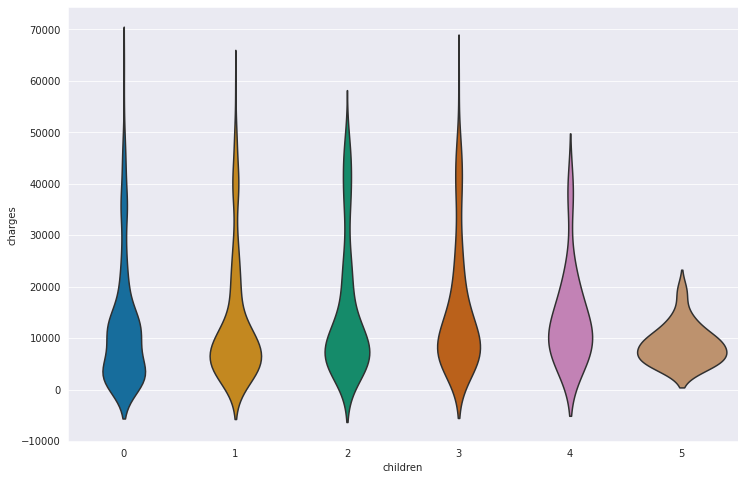

In [108]:
#Stworzenie wykresu skrzypcowego dla kategorii 'children'
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.violinplot(data=insurance, 
               x='children', 
               y='charges',
               palette = "colorblind",
               inner=None)
plt.show()

Analizując wykres skrzypcowy można dostrzec, że koszty ubezpieczenie rozkładają się bardzo podobnie w grupach od 0 do 4 dzieci, natomiast osoby posiadające 5 dzieci zdecydowanie częściej ponoszą bardzo podobne koszty zbliżone do średniej w tej grupi osób. Istnieje też znaczna różnica pomiędzy rozpiętością kosztów pomiędzy tą grupą a pozostałymi. Stąd można wywnioskować, że ilość posiadanych dzieci przy ich liczbie większej od 4 może wpływać na koszty ubezpieczenia.

##Smoker

In [125]:
print( f'Liczba wszystkich obserwacji to : {len(insurance.index)}')

Liczba wszystkich obserwacji to : 1338


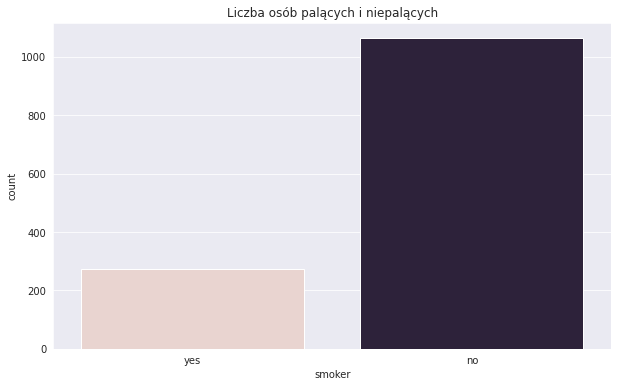

In [110]:
#Wykres reprezentujący liczbę osób palących i niepalących

plt.figure(figsize=(10,6))
sns.countplot(data=insurance, 
              x='smoker',
              palette = "ch:")
plt.title('Liczba osób palących i niepalących')
plt.show()

W badaniu wzięło udział znacznie wiecej palących niż niepalących, jednak dane są reprezentatywne ponieważ w grupie 1338 obserwacji ponad 200 stanowią osoby niepalące

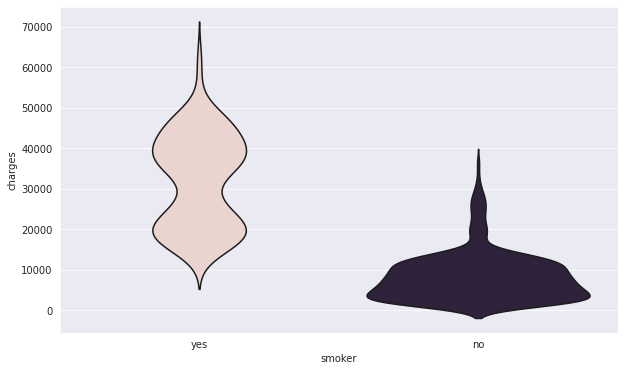

In [128]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.violinplot(data=insurance, 
               x='smoker', 
               y='charges',
               palette = "ch:",
               inner=None)
plt.show()

Kategoria palący/niepalący ma znaczący wpływ na zmienną 'charges' co widać na powyższym wykresie. Osoby palące ponoszą zwykle wyższe koszta związane z opłaceniem ubezpieczenia. Można również zaobserwować, że duża część osób niepalących płaci dość niski koszt ubezpieczenia (wykres skrzypcowy jest znacznie bardziej 'rozlany' u podstawy co oznacza, że w tej grupie opłaty większości osób są bliżej dolnej granicy rozpiętości stawek dla tej grupy) W grupie osób palących minimalna oraz maksymalna kwota ubezpieczenia jest róznież o wiele wyższa.

#Region

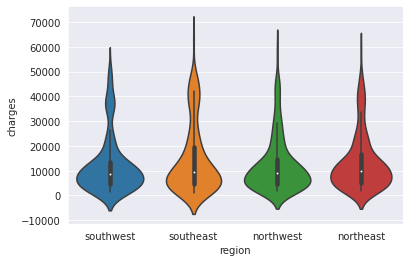

In [ ]:
sns.set_style('darkgrid')
sns.violinplot(data=insurance, x='region', y='charges')

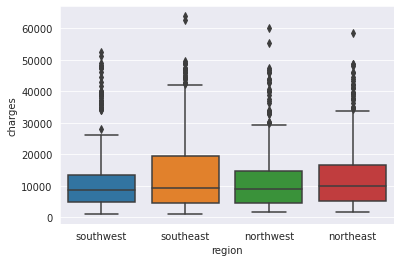

In [ ]:
sns.boxplot(data=insurance, x='region', y='charges')

Na podstawie wykresów widzimy, że na kwotę ubezpieczenie wpływa wiek, BMI oraz osoby palące, natomiast liczba dzieci ma niewielki wływ. Nie zobserwowano wpływu na kwotę ubezpieczenia od regionu z którego pochodzi dana osoba oraz jej płci.

Kategorię płeć usuwamy, ponieważ w tym zagadnieniu nie ma on wpływu. Poza tym dana płeć nie może być wykorzystywana do oceny (uprzedzenia)

Usuwamy kategorię 'sex' i 'region'

# Podział zamiennych na kategoryczne i numeryczne

In [ ]:
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['smoker','region']
target = 'charges'

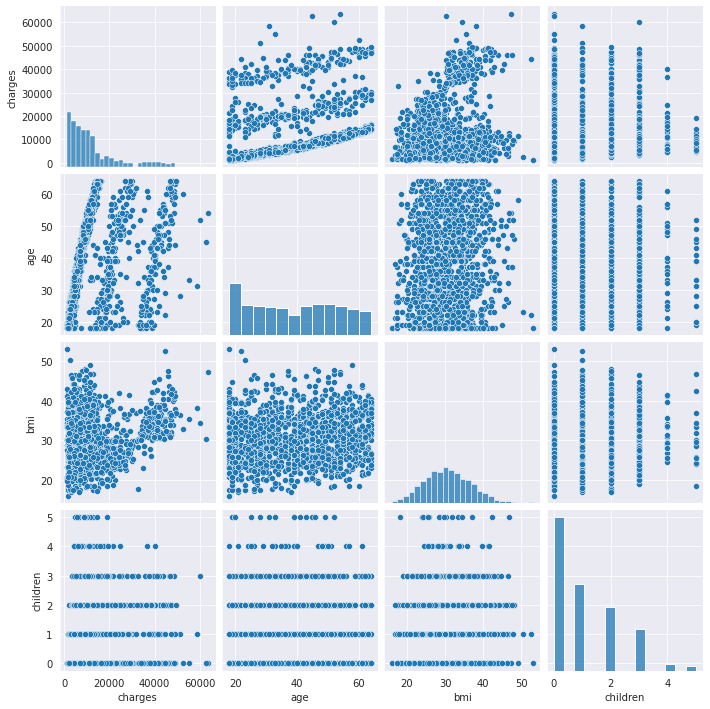

In [ ]:
sns.pairplot(insurance[[target]+numeric_features])
plt.show()

In [ ]:
insurance.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [ ]:
smoker = pd.get_dummies(insurance['smoker'], drop_first=True)

In [ ]:
insurance_new = insurance.copy()
insurance_new = insurance_new.drop(columns={'sex','region','smoker'})

insurance_new=pd.concat([insurance_new,smoker],axis=1)

In [ ]:
insurance_new = insurance_new.rename(columns={'yes':'smoker'})


In [ ]:
insurance_new

,age,bmi,children,charges,smoker
0,19,27.900,0,16884.92400,1
1,18,33.770,1,1725.55230,0
2,28,33.000,3,4449.46200,0
3,33,22.705,0,21984.47061,0
4,32,28.880,0,3866.85520,0
...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0
1334,18,31.920,0,2205.98080,0
1335,18,36.850,0,1629.83350,0
1336,21,25.800,0,2007.94500,0


smoker:
1 - palący
2 - niepalący

In [ ]:
insurance_new.describe()

,age,bmi,children,charges,smoker
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,0.204783
std,14.049960,6.098187,1.205493,12110.011237,0.403694
min,18.000000,15.960000,0.000000,1121.873900,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000
50%,39.000000,30.400000,1.000000,9382.033000,0.000000
75%,51.000000,34.693750,2.000000,16639.912515,0.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000


# Tworzenie modelu na podstawie jednej zmiennej

In [ ]:
X = insurance_new[['age']]
y= insurance_new['charges']

### Zbiór testowy, treningowy i walidacyjny

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# Podział zbioru na testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [ ]:
# Stworzenie zbioru walidacyjnego
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=2022)
# nsplits - ilość przedziałów
# shuffle - potawoanie danych (może zdarzyć się tak, że jak nie potasujemy danych to mogę być to posortowane)

for train, val in cv.split(X_train, y_train):
  # train i vel są indeksami podzielonego zbioru treningowego
  X_tr, y_tr = X_train.iloc[train], y_train.iloc[train]
  X_val, y_val = X_train.iloc[val], y_train.iloc[val]

### Stworzenie modelu drzewa decyzyjnego 

In [ ]:
from sklearn.model_selection import GridSearchCV #sprawdzanie kombinacji parametrów
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
tree_model = DecisionTreeRegressor()
# Nasz model sprawdzi poniższe hiperparametry
params = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1, 2, 5, 7, 10]}

tree_regression_gridsearch = GridSearchCV(tree_model, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=10,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
tree_regression_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', tree_regression_gridsearch.best_params_)

tree_regression_model = tree_regression_gridsearch.best_estimator_

Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV 1/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 1/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-190484596.778 total time=   0.0s
[CV 2/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 2/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-130014076.455 total time=   0.0s
[CV 3/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 3/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-129780765.569 total time=   0.0s
[CV 4/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 4/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-107909116.637 total time=   0.0s
[CV 5/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 5/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-142791166.150 total time=   0.0s
[CV 6/10; 1/75] START max_depth=1, min_samples_leaf=1.........

#####Najlepszymi parametrami dla drzewa decyzyjnego są:
#####'max_depth': 2, 
#####'min_samples_leaf': 1

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


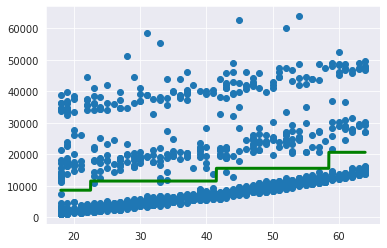

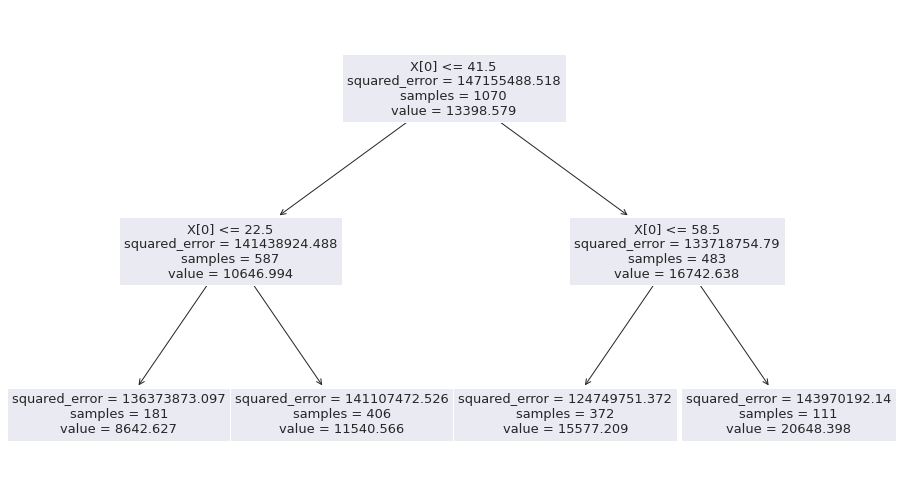

In [ ]:
from sklearn import tree

model_tree = DecisionTreeRegressor(max_depth= 2, min_samples_leaf=1)
model_tree.fit(X_train,y_train)

X_linespace = np.arange(X.min()[0],X.max()[0], step=0.001).reshape(-1,1)
y_fitted_tree = model_tree.predict(X_linespace)
plt.scatter(X, y)
plt.plot(X_linespace, y_fitted_tree, linewidth=3, color='green')
plt.show()
    
plt.figure(figsize=(16,9))
tree.plot_tree(model_tree)
plt.show()

In [ ]:
y_predict_train_model_tree = model_tree.predict(X_train)
y_predict_test_model_tree = model_tree.predict(X_test)

## Ocena modelu drzewa decyzyjnego dla jednej zmiennej

###Dummy model

In [ ]:
# Stworzenie modelu, do którego możena porównać nowo stworzone modele
dummy_model = DummyRegressor(strategy='mean') # użycie dummymodel jako model porównawczy
dummy_model.fit(X_train, y_train) #trenowanie
y_train_dummy = dummy_model.predict(X_train) #przewidywany y_dummy na zbiorze treningowym
y_test_dummy  = dummy_model.predict(X_test) #przewidywany y_dummy na zbiorze testowym

DummyRegressor()

### Współczynnik determinacji

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
print(f'Dummy Train R^2: {r2_score(y_train,y_train_dummy)}') #kolejność jest istotna, najpierw podajemy prawdziwy y , a potem prognozowany
print(f'RL Model Train R^2: {r2_score(y_train, y_predict_train_model_tree)}')

Dummy Train R^2: 0.0
RL Model Train R^2: 0.08316887258887151


Im bliżej R^2 jest 1 tym model jest lepszy. Nasz model jest lepszy niż dummy model.

###MAE

In [ ]:
from sklearn.metrics import mean_absolute_error

print(f'Train')
print(f'DUmmy: {mean_absolute_error(y_train,y_train_dummy)}')
print(f'RL Model: {mean_absolute_error(y_train,y_predict_train_model_tree)}')

print(f'\nTest:')
print(f'DUmmy: {mean_absolute_error(y_test,y_test_dummy)}')
print(f'RL Model: {mean_absolute_error(y_test,y_predict_test_model_tree)}')

Train
DUmmy: 9172.631949962091
RL Model: 9100.967030501119

Test:
DUmmy: 9004.29746646955
RL Model: 8727.313881117267


In [ ]:
(8727-9100)/8727

-0.04274091898705168

###MAPE

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
print(f'\nTest:')
print(f'DUmmy: {mean_absolute_percentage_error(y_test,y_test_dummy)*100}%')
print(f'RL Model: {mean_absolute_percentage_error(y_test,y_predict_test_model_tree)*100}%')


Test:
DUmmy: 160.6775952090012%
RL Model: 126.12617705819275%


###MSE

In [ ]:
from sklearn.metrics import mean_squared_error
mse_dummy = mean_squared_error(y_test, y_test_dummy)
mse_model = mean_squared_error(y_test, y_predict_test_model_tree)
print(f'\nTest:')
print(f'DUmmy: {mse_dummy}')
print(f'RL Model: {mse_model}')


Test:
DUmmy: 144178448.72444746
RL Model: 123322253.14684914


###RMSE

In [ ]:
from math import sqrt
# mozna też zamiast obliczać można dodać parametr 'squered =False' : mse_model = mean_squared_error(y_test, y_predict_test, squared = False)
print(f'\nTest:')
print(f'DUmmy: {sqrt(mse_dummy)}')
print(f'RL Model: {sqrt(mse_model)}')


Test:
DUmmy: 12007.433061418558
RL Model: 11105.055296883898


## Stworzenie modelu regresji wielomianowej

Stworzenie y prognozowanych na zbiorze testowym i treningowym

In [ ]:
from sklearn.preprocessing import StandardScaler
polynomial_regression_pipeline = make_pipeline(StandardScaler(),PolynomialFeatures(),
                                               LinearRegression())
# Nasz model sprawdzi poniższe hiperparametry
params = {'polynomialfeatures__degree': [1, 2, 3, 4, 5, 6]}

polynomial_regression_gridsearch = GridSearchCV(polynomial_regression_pipeline, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=10,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
polynomial_regression_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', polynomial_regression_gridsearch.best_params_)

polynomial_regression_model = polynomial_regression_gridsearch.best_estimator_

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 1/10; 1/6] END polynomialfeatures__degree=1;, score=-193191016.709 total time=   0.0s
[CV 2/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 2/10; 1/6] END polynomialfeatures__degree=1;, score=-126141609.766 total time=   0.0s
[CV 3/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 3/10; 1/6] END polynomialfeatures__degree=1;, score=-130634677.772 total time=   0.0s
[CV 4/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 4/10; 1/6] END polynomialfeatures__degree=1;, score=-101562730.700 total time=   0.0s
[CV 5/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 5/10; 1/6] END polynomialfeatures__degree=1;, score=-140170985.590 total time=   0.0s
[CV 6/10; 1/6] START polynomialfeatures__degree=1...............................
[CV

In [ ]:
y_predict_train_polynomial_regression = polynomial_regression_model.predict(X_train)
y_predict_test_polynomial_regression = polynomial_regression_model.predict(X_test)

## Ocena modelu regresji dla jednej zmiennej

### Współczynnik determinacji

In [ ]:
print(f'Dummy Train R^2: {r2_score(y_train,y_train_dummy)}') #kolejność jest istotna, najpierw podajemy prawdziwy y , a potem prognozowany
print(f'RL Model Train R^2: {r2_score(y_train, y_predict_train_polynomial_regression)}')

Dummy Train R^2: 0.0
RL Model Train R^2: 0.0760296179539326


###MAE

In [ ]:
print(f'Train')
print(f'DUmmy: {mean_absolute_error(y_train,y_train_dummy)}')
print(f'RL Model: {mean_absolute_error(y_train,y_predict_train_polynomial_regression)}')

print(f'\nTest:')
print(f'DUmmy: {mean_absolute_error(y_test,y_test_dummy)}')
print(f'RL Model: {mean_absolute_error(y_test,y_predict_test_polynomial_regression)}')

Train
DUmmy: 9172.631949962091
RL Model: 9199.090412957323

Test:
DUmmy: 9004.29746646955
RL Model: 8781.583709931885


###MAPE

In [ ]:
print(f'\nTest:')
print(f'DUmmy: {mean_absolute_percentage_error(y_test,y_test_dummy)*100}%')
print(f'RL Model: {mean_absolute_percentage_error(y_test,y_predict_test_polynomial_regression)*100}%')


Test:
DUmmy: 160.6775952090012%
RL Model: 126.66877932250058%


### MSE

In [ ]:
mse_dummy = mean_squared_error(y_test, y_test_dummy)
mse_model = mean_squared_error(y_test, y_predict_test_model_tree)
print(f'\nTest:')
print(f'DUmmy: {mse_dummy}')
print(f'RL Model: {mse_model}')


Test:
DUmmy: 144178448.72444746
RL Model: 123322253.14684914


###RMSE

In [ ]:
print(f'\nTest:')
print(f'DUmmy: {sqrt(mse_dummy)}')
print(f'RL Model: {sqrt(mse_model)}')


Test:
DUmmy: 12007.433061418558
RL Model: 11105.055296883898


# Dla wielu zmiennych

In [ ]:
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['smoker','region']
targer = 'charges'

In [ ]:
X = insurance_new.drop([target], axis=1)
display(X.iloc[:3])

y = insurance_new[target]
display(y.iloc[:3])

,age,bmi,children,smoker
0,19,27.90,0,1
1,18,33.77,1,0
2,28,33.00,3,0


0    16884.9240
1     1725.5523
2     4449.4620
Name: charges, dtype: float64

##Podział na zbiór treningowy i testowy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

##Model drzewa decyzyjnego dla wielu zmiennych

In [ ]:
tree_model = DecisionTreeRegressor()
# Nasz model sprawdzi poniższe hiperparametry
params = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1, 2, 5, 7, 10]}

tree_regression_gridsearch = GridSearchCV(tree_model, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=10,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
tree_regression_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', tree_regression_gridsearch.best_params_)

polynomial_regression_model = tree_regression_gridsearch.best_estimator_

Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV 1/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 1/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-72993467.989 total time=   0.0s
[CV 2/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 2/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-55412238.175 total time=   0.0s
[CV 3/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 3/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-59358510.916 total time=   0.0s
[CV 4/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 4/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-51244070.630 total time=   0.0s
[CV 5/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 5/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-64440320.672 total time=   0.0s
[CV 6/10; 1/75] START max_depth=1, min_samples_leaf=1..............

Najlepszymi parametrami dla drzewa decyzyjnego są:
'max_depth': 5 ,
'min_samples_leaf': 10

In [ ]:
from sklearn import tree

model_tree = DecisionTreeRegressor(max_depth= 5, min_samples_leaf=10)
model_tree.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)

In [ ]:
y_predict_train_model_tree = model_tree.predict(X_train)
y_predict_test_model_tree = model_tree.predict(X_test)

##Ocena modelu drzewa decyzyjnego dla wielu zmiennych

###Współczynnyk determinacji

In [ ]:
print(f'Dummy Train R^2: {r2_score(y_train,y_train_dummy)}') #kolejność jest istotna, najpierw podajemy prawdziwy y , a potem prognozowany
print(f'RL Model Train R^2: {r2_score(y_train, y_predict_train_model_tree)}')

Dummy Train R^2: 0.0
RL Model Train R^2: 0.8709228296197578


Nasz współczynnik R^2 jest dużo lepszy przy wykorzystaniu wielu zmiennych w modelu drzewa decyzyjnego

###MAE

In [ ]:

print(f'Train')
print(f'DUmmy: {mean_absolute_error(y_train,y_train_dummy)}')
print(f'RL Model: {mean_absolute_error(y_train,y_predict_train_model_tree)}')

print(f'\nTest:')
print(f'DUmmy: {mean_absolute_error(y_test,y_test_dummy)}')
print(f'RL Model: {mean_absolute_error(y_test,y_predict_test_model_tree)}')

Train
DUmmy: 9172.631949962091
RL Model: 2478.0872984237353

Test:
DUmmy: 9004.29746646955
RL Model: 2431.175947956803


###MAPE

In [ ]:
print(f'\nTest:')
print(f'DUmmy: {mean_absolute_percentage_error(y_test,y_test_dummy)*100}%')
print(f'RL Model: {mean_absolute_percentage_error(y_test,y_predict_test_model_tree)*100}%')


Test:
DUmmy: 160.6775952090012%
RL Model: 32.12169948084587%


###MSE

In [ ]:
mse_dummy = mean_squared_error(y_test, y_test_dummy)
mse_model = mean_squared_error(y_test, y_predict_test_model_tree)
print(f'\nTest:')
print(f'DUmmy: {mse_dummy}')
print(f'RL Model: {mse_model}')


Test:
DUmmy: 144178448.72444746
RL Model: 15814948.192761773


###RMSE

In [ ]:
print(f'\nTest:')
print(f'DUmmy: {sqrt(mse_dummy)}')
print(f'RL Model: {sqrt(mse_model)}')


Test:
DUmmy: 12007.433061418558
RL Model: 3976.8012513528724


##Model regresji wielomianowej dla wielu zmiennych

In [ ]:
from sklearn.preprocessing import StandardScaler
polynomial_regression_pipeline = make_pipeline(StandardScaler(),PolynomialFeatures(),
                                               LinearRegression())
# Nasz model sprawdzi poniższe hiperparametry
params = {'polynomialfeatures__degree': [1, 2, 3, 4, 5, 6]}

polynomial_regression_gridsearch = GridSearchCV(polynomial_regression_pipeline, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=10,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
polynomial_regression_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', polynomial_regression_gridsearch.best_params_)

polynomial_regression_model = polynomial_regression_gridsearch.best_estimator_

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 1/10; 1/6] END polynomialfeatures__degree=1;, score=-48160316.885 total time=   0.0s
[CV 2/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 2/10; 1/6] END polynomialfeatures__degree=1;, score=-37917665.618 total time=   0.0s
[CV 3/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 3/10; 1/6] END polynomialfeatures__degree=1;, score=-39821127.747 total time=   0.0s
[CV 4/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 4/10; 1/6] END polynomialfeatures__degree=1;, score=-33187818.799 total time=   0.0s
[CV 5/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 5/10; 1/6] END polynomialfeatures__degree=1;, score=-52452345.335 total time=   0.0s
[CV 6/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 6/10

In [ ]:
y_predict_train_polynomial_regression = model_tree.predict(X_train)
y_predict_test_polynomial_regression = model_tree.predict(X_test)

## Ocena modelu regresji dla wielu zmiennych

###R^2

In [ ]:
print(f'Dummy Train R^2: {r2_score(y_train,y_train_dummy)}') #kolejność jest istotna, najpierw podajemy prawdziwy y , a potem prognozowany
print(f'RL Model Train R^2: {r2_score(y_train, y_predict_train_polynomial_regression)}')

Dummy Train R^2: 0.0
RL Model Train R^2: 0.8709228296197578


###MAE

In [ ]:
print(f'Train')
print(f'DUmmy: {mean_absolute_error(y_train,y_train_dummy)}')
print(f'RL Model: {mean_absolute_error(y_train,y_predict_train_polynomial_regression)}')

print(f'\nTest:')
print(f'DUmmy: {mean_absolute_error(y_test,y_test_dummy)}')
print(f'RL Model: {mean_absolute_error(y_test,y_predict_test_polynomial_regression)}')

Train
DUmmy: 9172.631949962091
RL Model: 2478.0872984237353

Test:
DUmmy: 9004.29746646955
RL Model: 2431.175947956803


###MAPE

In [ ]:
print(f'\nTest:')
print(f'DUmmy: {mean_absolute_percentage_error(y_test,y_test_dummy)*100}%')
print(f'RL Model: {mean_absolute_percentage_error(y_test,y_predict_test_polynomial_regression)*100}%')


Test:
DUmmy: 160.6775952090012%
RL Model: 32.12169948084587%


###MSE

In [ ]:
mse_dummy = mean_squared_error(y_test, y_test_dummy)
mse_model = mean_squared_error(y_test, y_predict_test_polynomial_regression)
print(f'\nTest:')
print(f'DUmmy: {mse_dummy}')
print(f'RL Model: {mse_model}')


Test:
DUmmy: 144178448.72444746
RL Model: 15814948.192761773


###RMSE

In [ ]:
print(f'\nTest:')
print(f'DUmmy: {sqrt(mse_dummy)}')
print(f'RL Model: {sqrt(mse_model)}')


Test:
DUmmy: 12007.433061418558
RL Model: 3976.8012513528724


#Prezentacja wyników

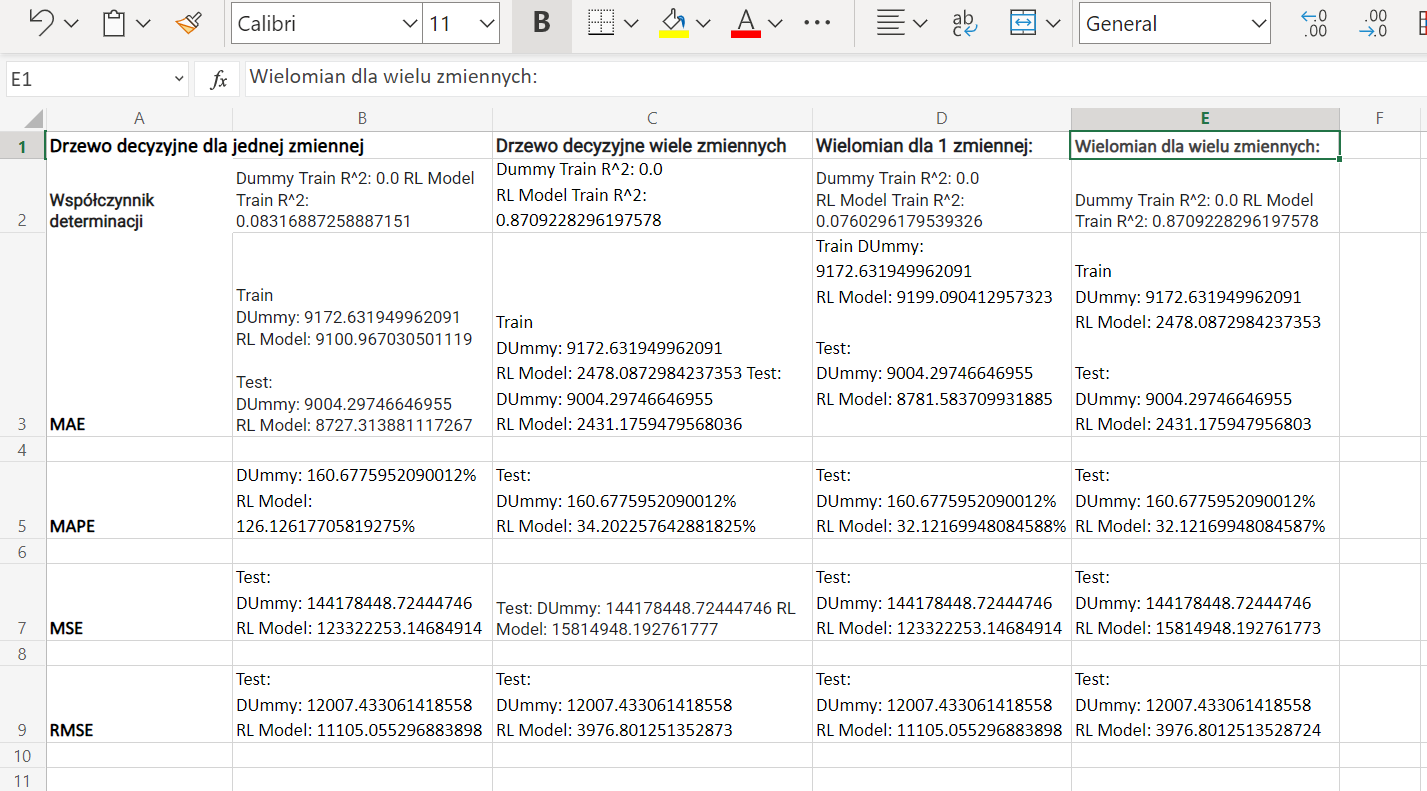